<a href="https://colab.research.google.com/github/MoralesCMaJo/Tarea-2--An-lisis-de-series-temporales/blob/main/12_Forescasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas yfinance matplotlib numpy

# Data frame

In [ ]:
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

# Descargar los datos utilizando el método .download()
raw_data = yf.download(tickers="^GSPC ^FTSE ^N225 ^GDAXI", start="1994-01-07", end="2023-09-23", interval="1d", group_by='ticker', auto_adjust=True, threads=True)

# Crear una copia de respaldo en caso de que se necesite
df_comp = raw_data.copy()

# Agregar nuevas columnas al conjunto de datos
df_comp['spx'] = df_comp['^GSPC'].Close
df_comp['dax'] = df_comp['^GDAXI'].Close
df_comp['ftse'] = df_comp['^FTSE'].Close
df_comp['nikkei'] = df_comp['^N225'].Close

# Eliminar la primera fila si es necesario (ajustar a tus requisitos)
# df_comp = df_comp.iloc[1:]

# Eliminar los tickers originales del conjunto de datos
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']

# Establecer la frecuencia de los datos a días hábiles
df_comp = df_comp.asfreq('B')

# Rellenar valores faltantes hacia adelante
df_comp = df_comp.fillna(method='ffill')
# Restablecer el índice para que "Date" sea una columna
df_comp = df_comp.reset_index()

print(df_comp.head()) # Mostrar las primeras 5 filas para verificar la descarga
print(df_comp.tail()) # Verificar la última fecha en la serie

from google.colab import drive
drive.mount('/content/drive')

# Supongamos que ya tienes un DataFrame llamado 'df_comp' con tus datos

# Especifica el nombre del archivo CSV
nombre_archivo_csv = "Index_2023.csv"  # Reemplaza 'tu_archivo.csv' con el nombre que desees

# Guarda el DataFrame en un archivo CSV en Google Colab
df_comp.to_csv("Index_2023.csv", index=True)

# Mueve el archivo CSV a tu unidad de Google Drive
import shutil
ruta_destino_drive = "/content/drive/My Drive/" + "Index_2023.csv"
shutil.move("Index_2023.csv", ruta_destino_drive)

# Asegúrate de que los datos se hayan guardado en Google Drive
print(f"Los datos se han guardado en Google Drive en {ruta_destino_drive}.")

[*********************100%%**********************]  4 of 4 completed
        Date         spx          dax         ftse        nikkei
                                                                
0 1994-01-07  469.899994  2224.949951  3446.000000  18124.009766
1 1994-01-10  475.269989  2225.000000  3440.600098  18443.439453
2 1994-01-11  474.130005  2228.100098  3413.800049  18485.250000
3 1994-01-12  474.170013  2182.060059  3372.000000  18793.880859
4 1994-01-13  472.470001  2142.370117  3360.000000  18577.259766
           Date          spx           dax         ftse        nikkei
                                                                     
7746 2023-09-18  4453.529785  15727.120117  7652.899902  33533.089844
7747 2023-09-19  4443.950195  15664.480469  7660.200195  33242.589844
7748 2023-09-20  4402.200195  15781.589844  7731.700195  33023.781250
7749 2023-09-21  4330.000000  15571.860352  7678.600098  32571.029297
7750 2023-09-22  4320.060059  15557.290039  7683.899902 

# Package Installation: statsmodels, seaborn, arch

In [ ]:
!pip install statsmodels seaborn arch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 12.1 MB/s eta 0:00:00


# Packages

In [ ]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

# Loading the data

In [ ]:
raw_data = yfinance.download(tickers="^GSPC ^FTSE ^N225 ^GDAXI", start="1994-01-07", end="2023-09-23", interval="1d", group_by='ticker', auto_adjust=True, threads=True)


[*********************100%%**********************]  4 of 4 completed


In [ ]:
df_comp = raw_data.copy()
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

# Creating Returns

In [ ]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

# Splitting the Data

In [ ]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model_ar = ARIMA(df.ftse, order=(1, 0, 0))
results_ar = model_ar.fit()


In [ ]:
model_ar = ARIMA(df.ftse, order = (1,0,0))
results_ar = model_ar.fit()

# Simple Forecasting

In [ ]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2017-10-09,2544.729980,12976.400391,7507.899902,20690.710938,-0.180443,-0.199391,0.157920,0.000000,75.228529,25.597915,113.341903,0.000000
2017-10-10,2550.639893,12949.250000,7538.299805,20823.509766,0.232241,0.404906,-0.209229,0.641828,-96.823528,-51.981921,-150.167685,283.122833
2017-10-11,2555.239990,12970.679688,7533.799805,20881.269531,0.180351,-0.059695,0.165490,0.277378,-75.189897,7.663686,118.775225,122.356644
2017-10-12,2550.929932,12982.889648,7556.200195,20954.720703,-0.168675,0.297332,0.094135,0.351756,70.322300,-38.171579,67.562573,155.166476
2017-10-13,2553.169922,12991.870117,7535.399902,21155.179688,0.087811,-0.275275,0.069172,0.956629,-36.609111,35.339842,49.645773,421.987625


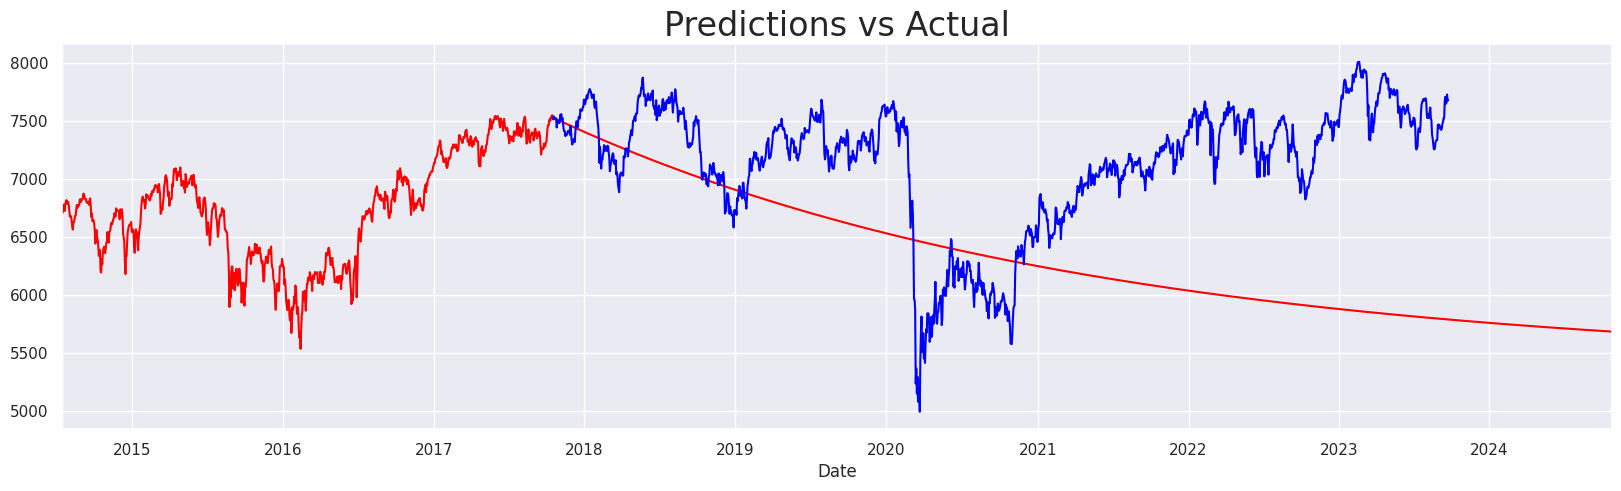

In [ ]:
# create variables that will help us change the periods easily instead of typing them up every time and make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2014-07-15"
end_date = "2015-01-01"

end_date = "2024-10-23"
df_pred = results_ar.predict(start = start_date, end = end_date)
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

# Using Returns Instead

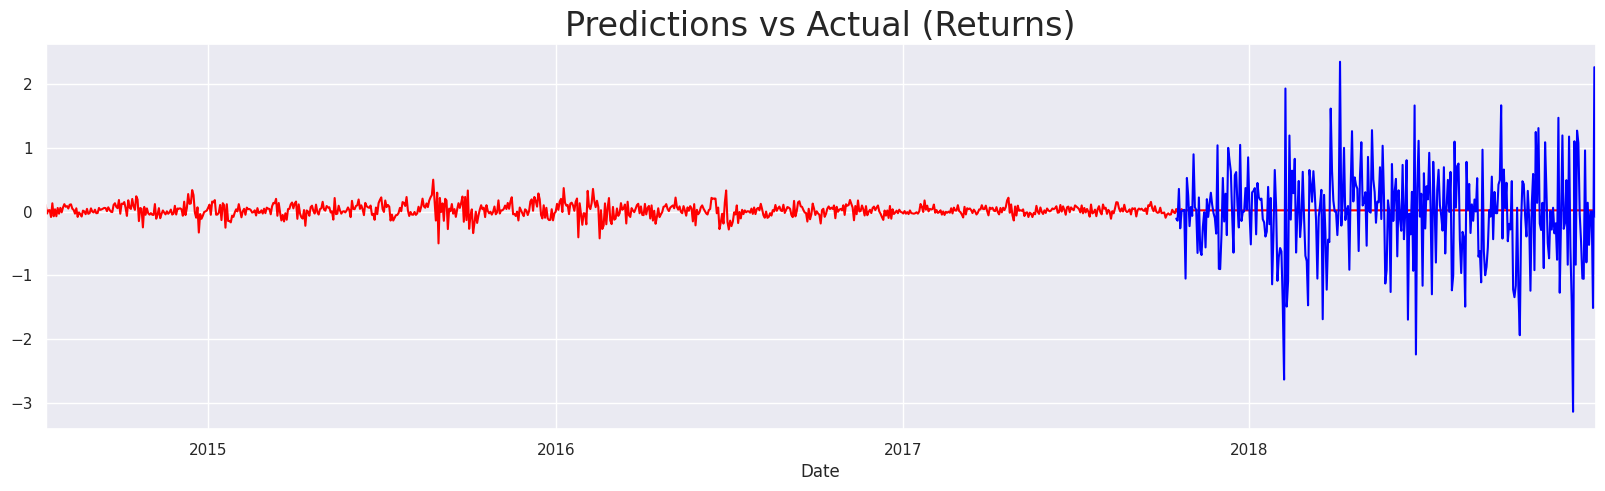

In [ ]:
end_date = "2018-12-31"

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date)

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 6199
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -9477.100
Date:                Sat, 14 Oct 2023   AIC                          18968.200
Time:                        16:49:05   BIC                          19015.325
Sample:                    01-11-1994   HQIC                         18984.539
                         - 10-13-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.013      1.481      0.139      -0.006       0.044
ar.L1         -0.0179      0.008     -2.235      0.025      -0.034      -0.002
ar.L2         -0.0522      0.007     -7.340      0.000      -0.066      -0.038
ar.L3         -0.0698      0.007     -9.809      0.000      -0.084      -0.056
ar.L4          0.0290      0.007      3.930      0.000       0.015       0.043
ar.L5         -0.0577      0.007     -8.092      0.000      -0.072      -0.044
sigma2         1.2457      0.012    104.116      0.000       1.222       1.269
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              8485.94
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# MA

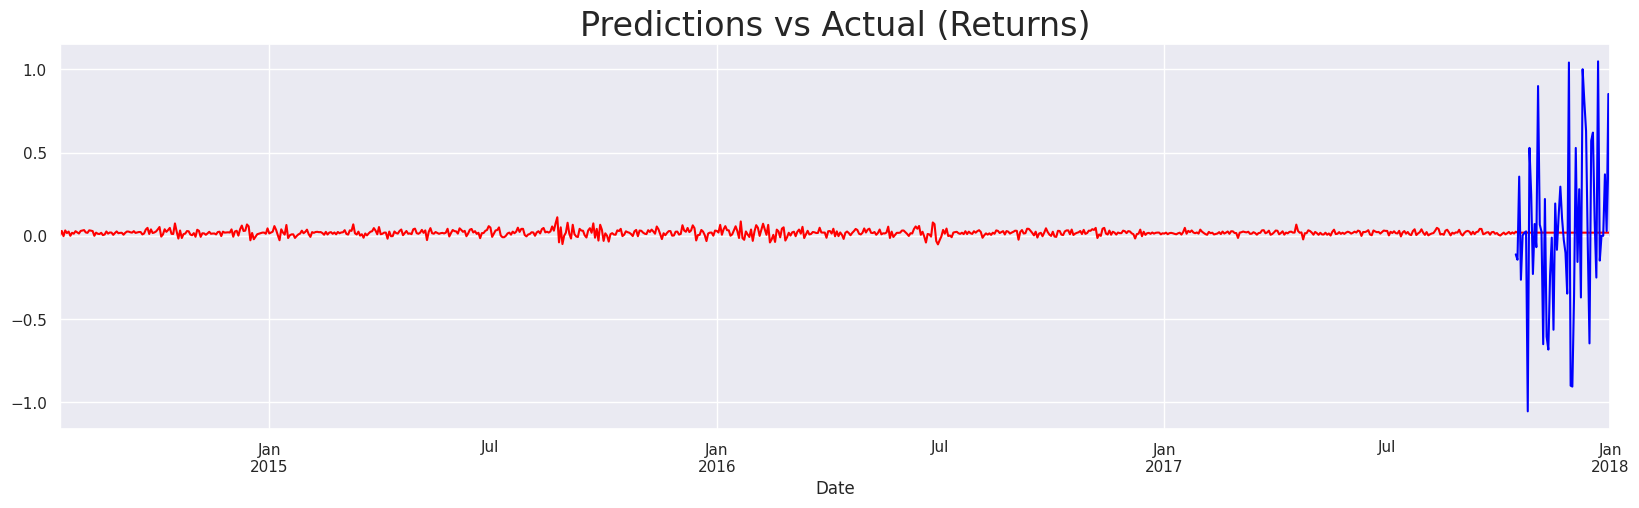

In [ ]:
end_date = "2018-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date)

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
df_pred_ma.head()

2014-07-15    0.002936
2014-07-16    0.029299
2014-07-17   -0.002042
2014-07-18    0.032248
2014-07-21    0.016338
Freq: B, Name: predicted_mean, dtype: float64

# ARMA

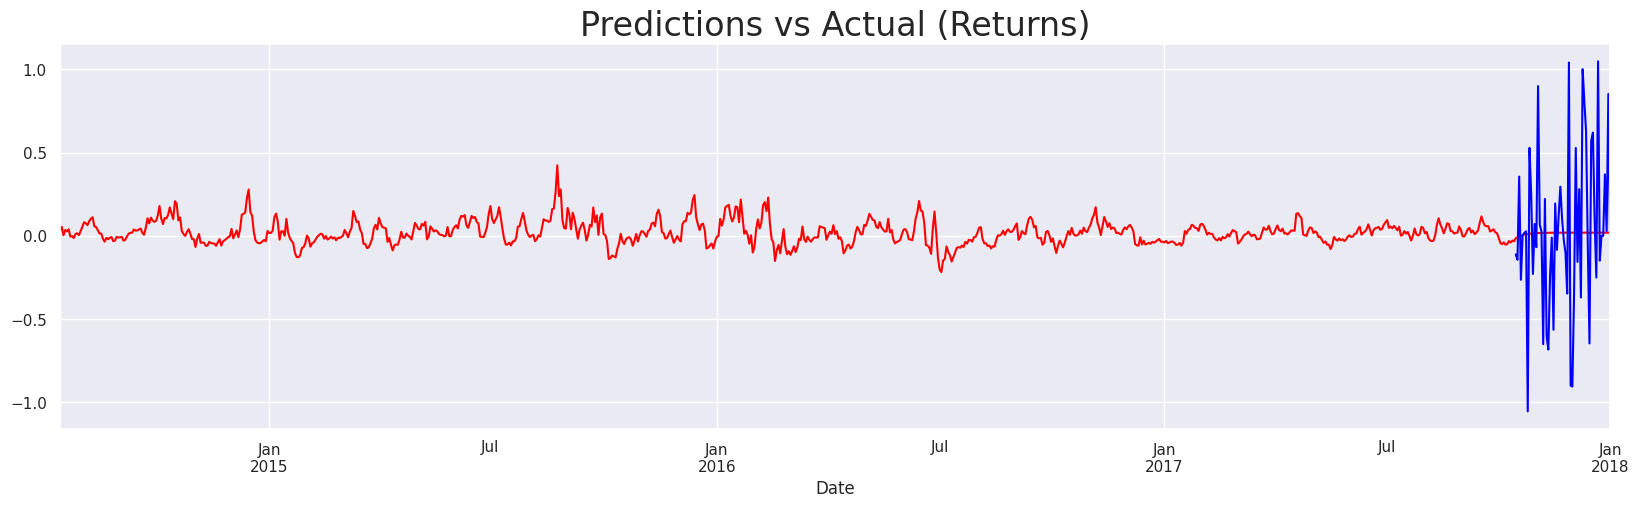

In [ ]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
df_pred_arma.head()

2014-07-15    0.032556
2014-07-16    0.053431
2014-07-17    0.003260
2014-07-18    0.034774
2014-07-21    0.026404
Freq: B, Name: predicted_mean, dtype: float64

In [ ]:
df_pred_arma.tail()

2017-12-26    0.018942
2017-12-27    0.018943
2017-12-28    0.018943
2017-12-29    0.018943
2018-01-01    0.018943
Freq: B, Name: predicted_mean, dtype: float64

# ARMAX

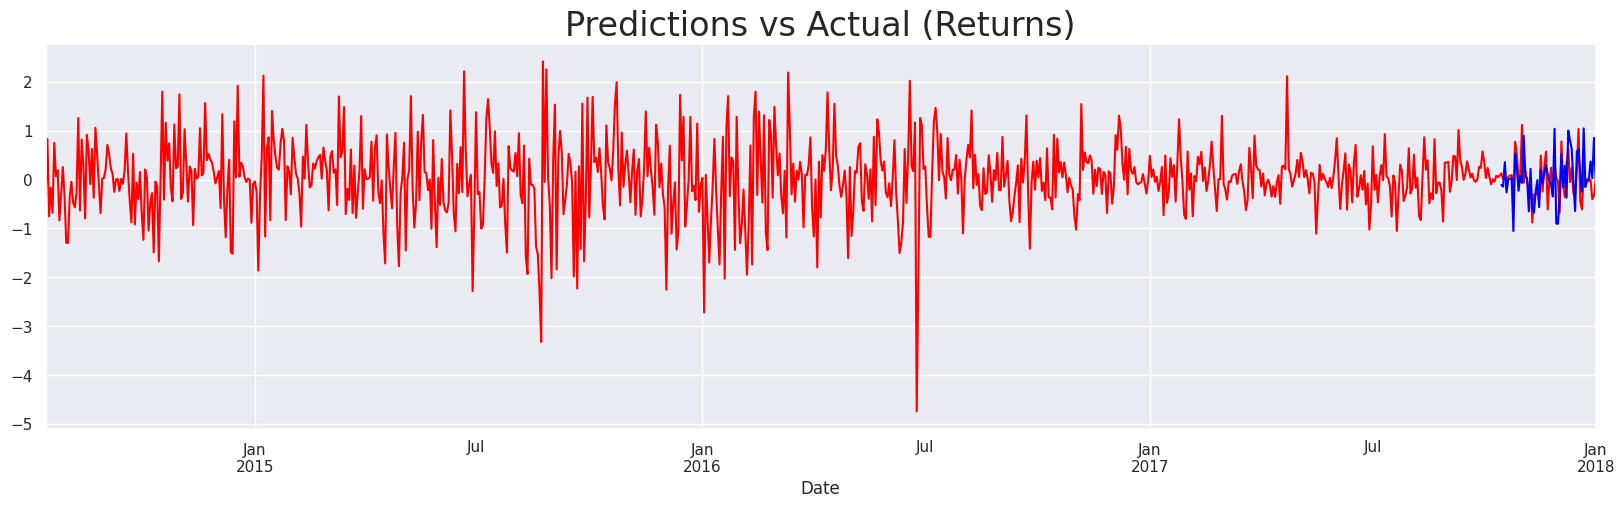

In [ ]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date,
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date])

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

# SARMA

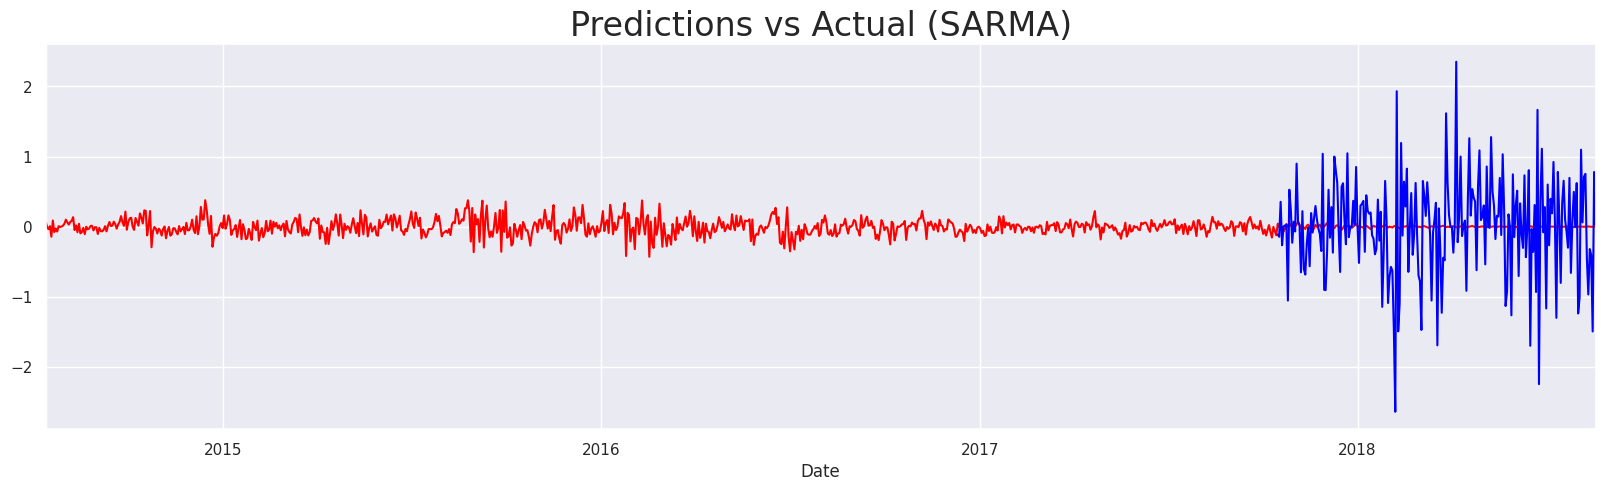

In [ ]:
end_date = "2018-08-18"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

# SARIMAX

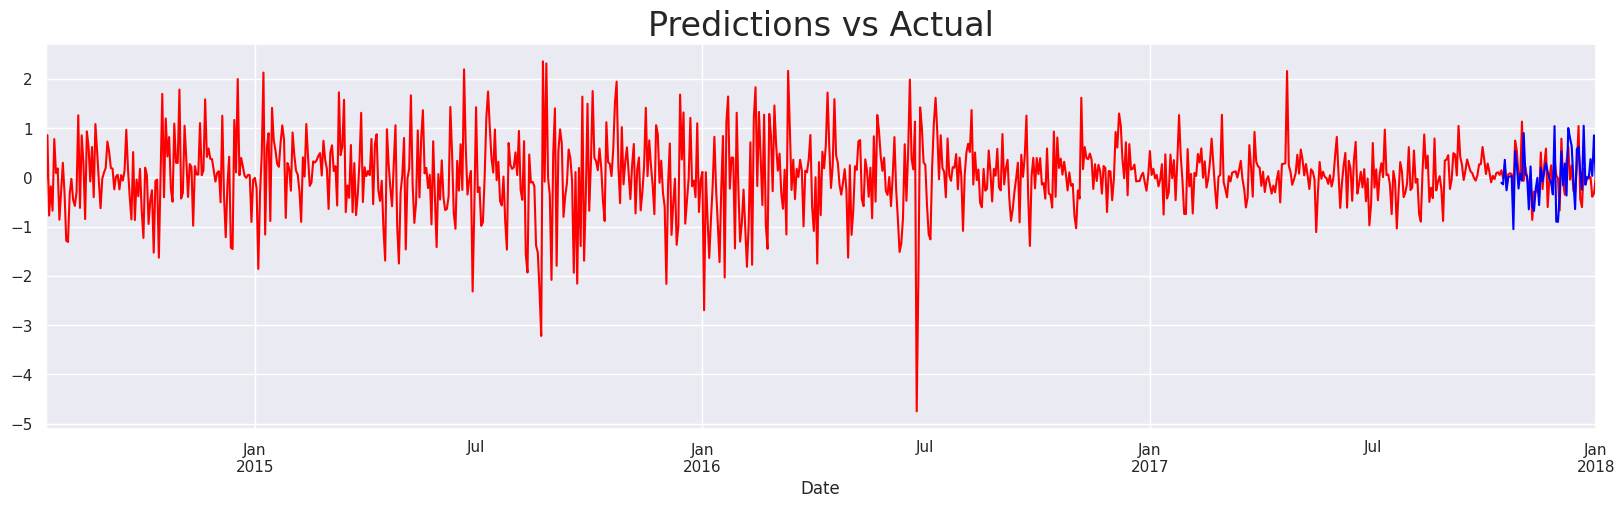

In [ ]:
end_date = "2018-01-01"
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:],
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date,
                                              exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date])

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

# Auto ARIMA

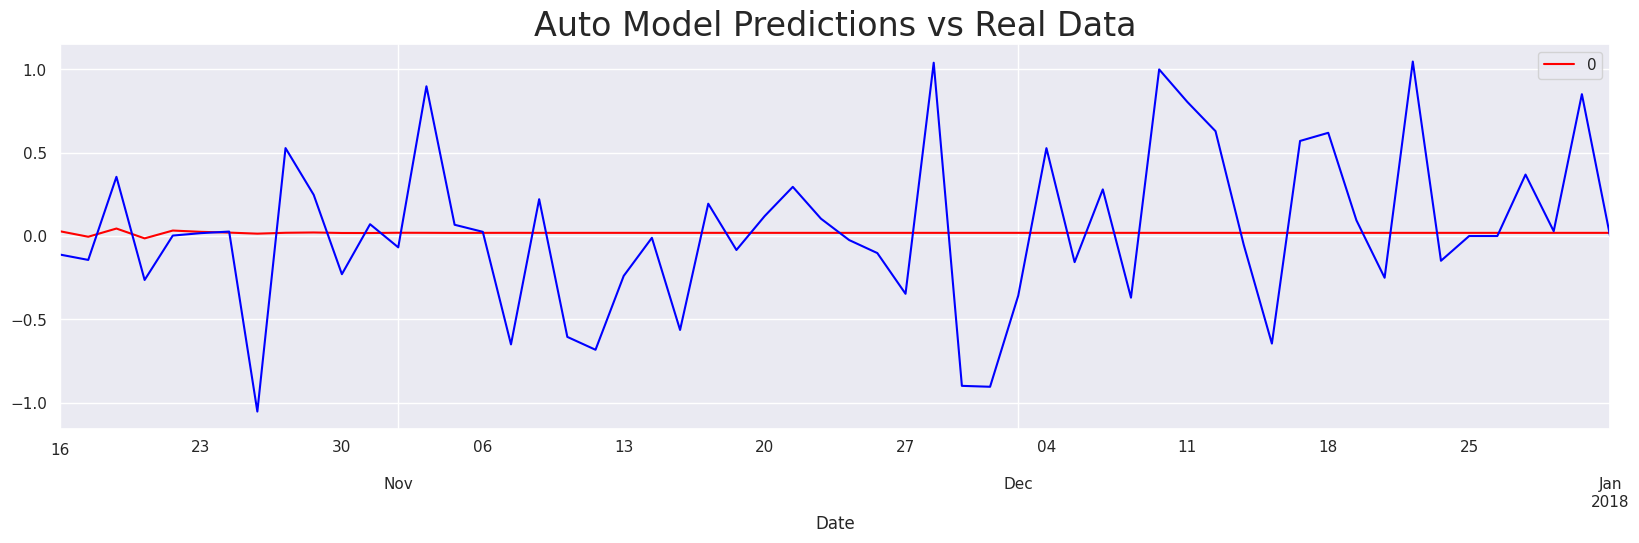

In [ ]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

# Comparing All the Models (Returns)

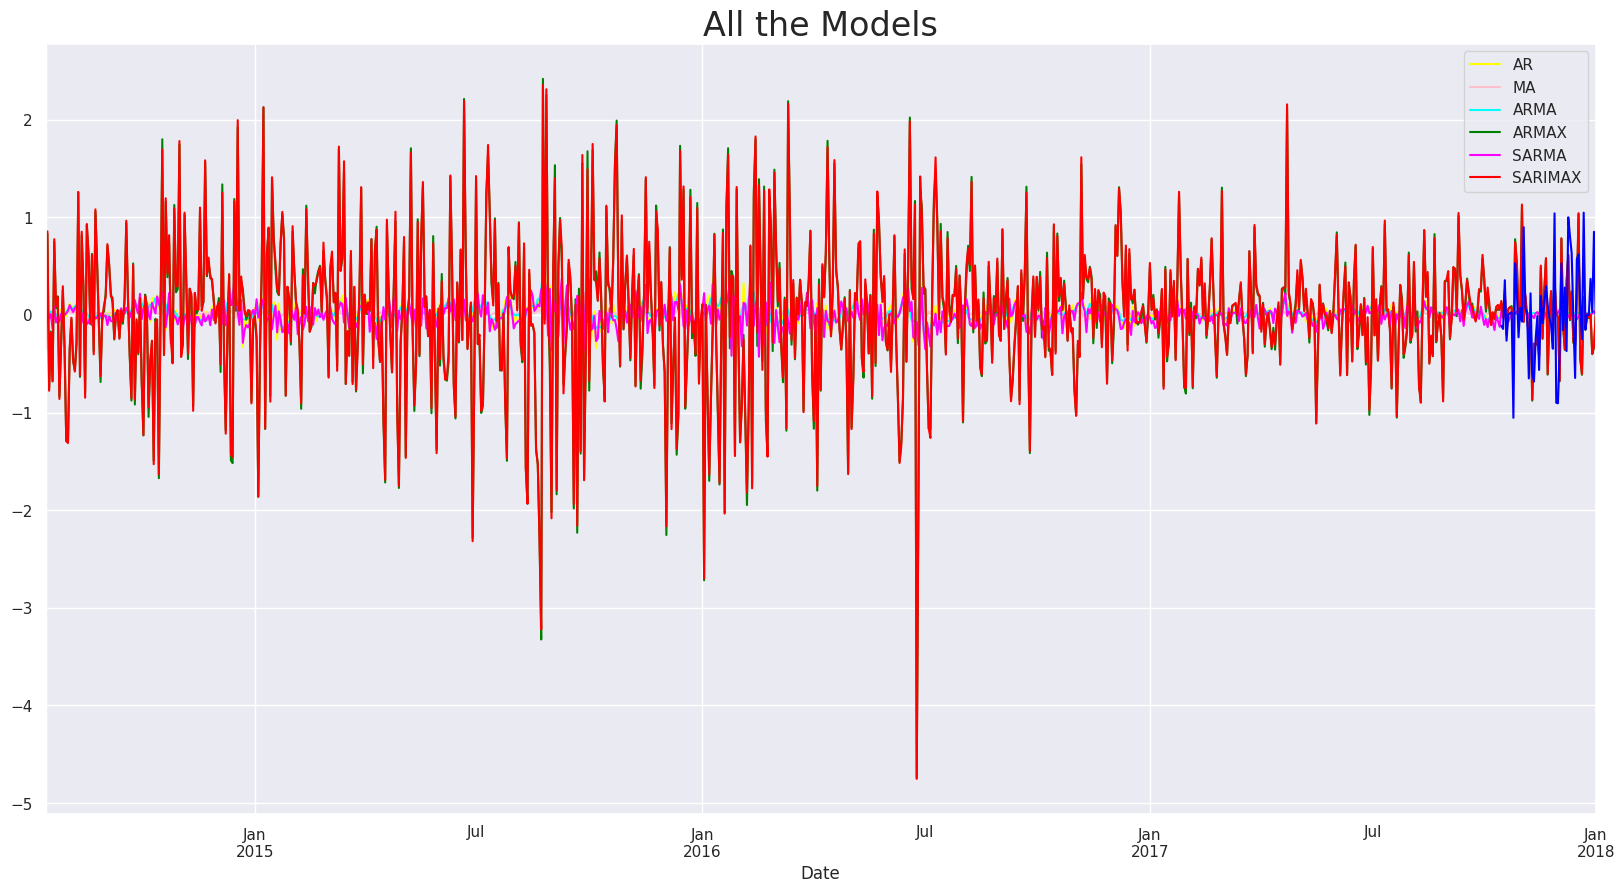

In [ ]:
end_date = "2018-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

# Forecasting Volatility

In [ ]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     65,   Neg. LLF: 7309.738663281408
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7309.738653886703
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


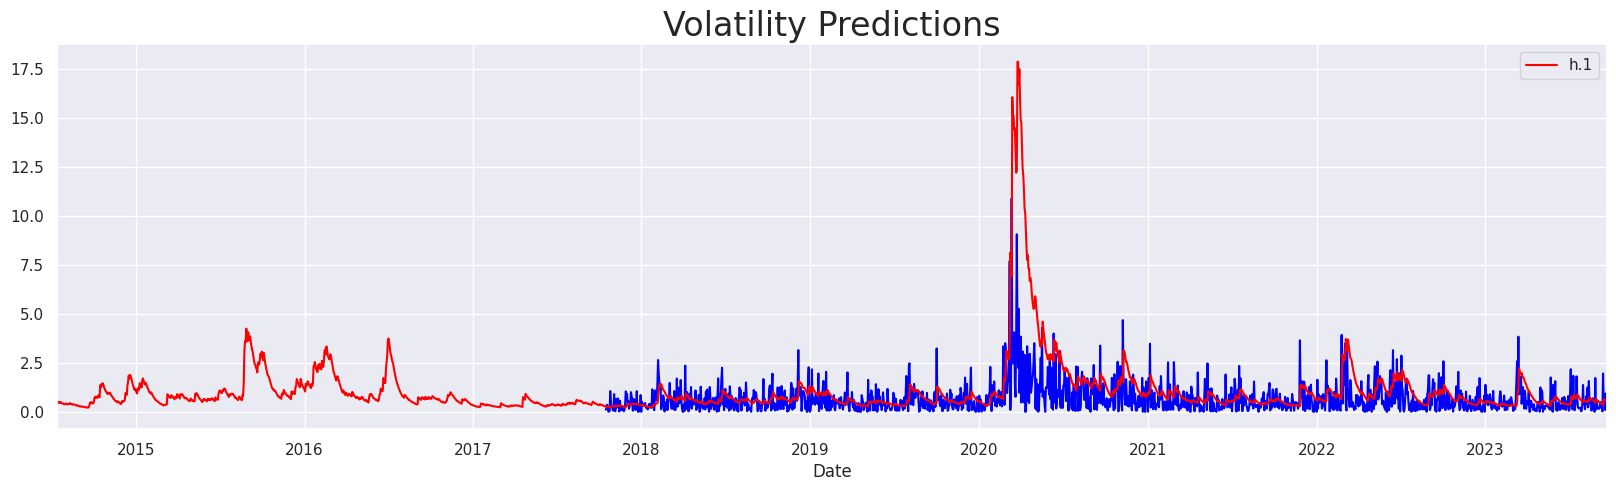

In [ ]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [ ]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-22,0.592579,0.597257,0.579149,0.628105,0.624752,0.658365,0.399562,0.428713,0.448781,0.477402,...,0.845117,0.858452,0.867196,0.876944,0.890821,0.905238,0.92213,0.936703,0.954782,0.976143


# Multvariate Regression Model

In [ ]:
from statsmodels.tsa.api import VAR
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 14, Oct, 2023
Time:                     17:16:40
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.115044
Nobs:                     6194.00    HQIC:                 0.0554077
Log likelihood:          -35145.2    FPE:                    1.02404
AIC:                    0.0237574    Det(Omega_mle):         1.01027
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039269         0.014429            2.722           0.006
L1.ret_spx           -0.107772         0.016282           -6.619           0.000
L1.ret_dax            0.058529         0.017317           

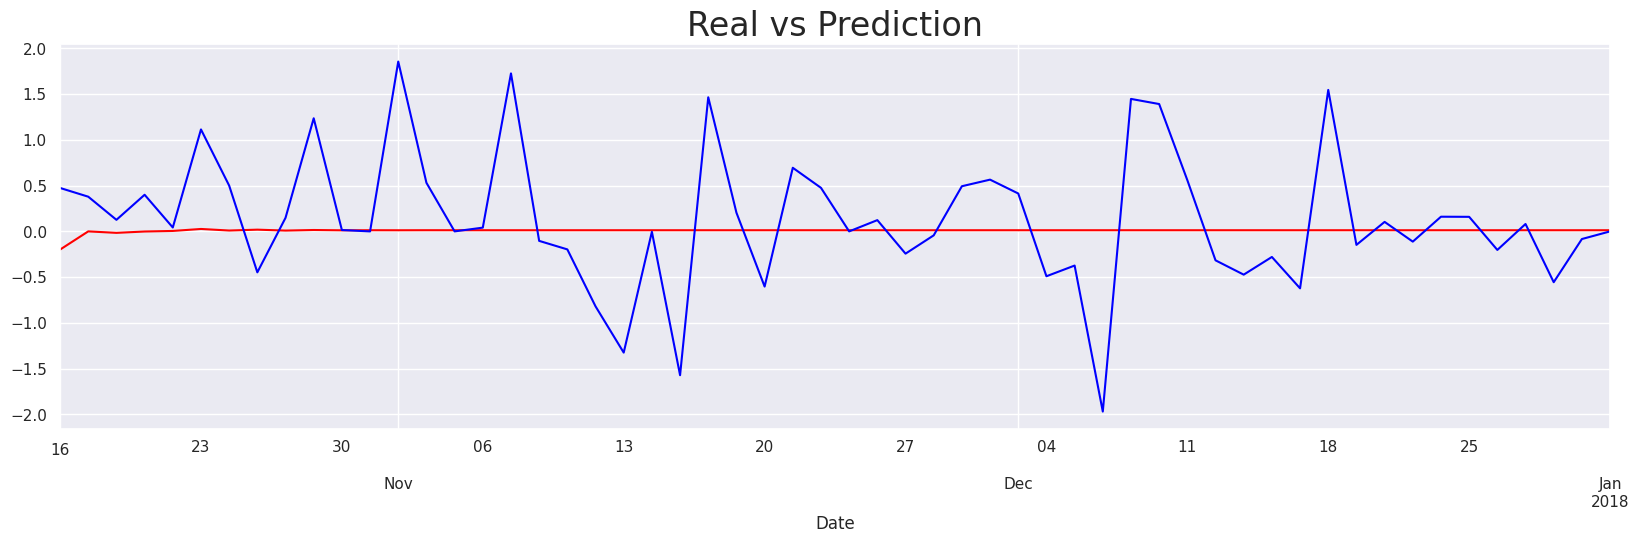

In [ ]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

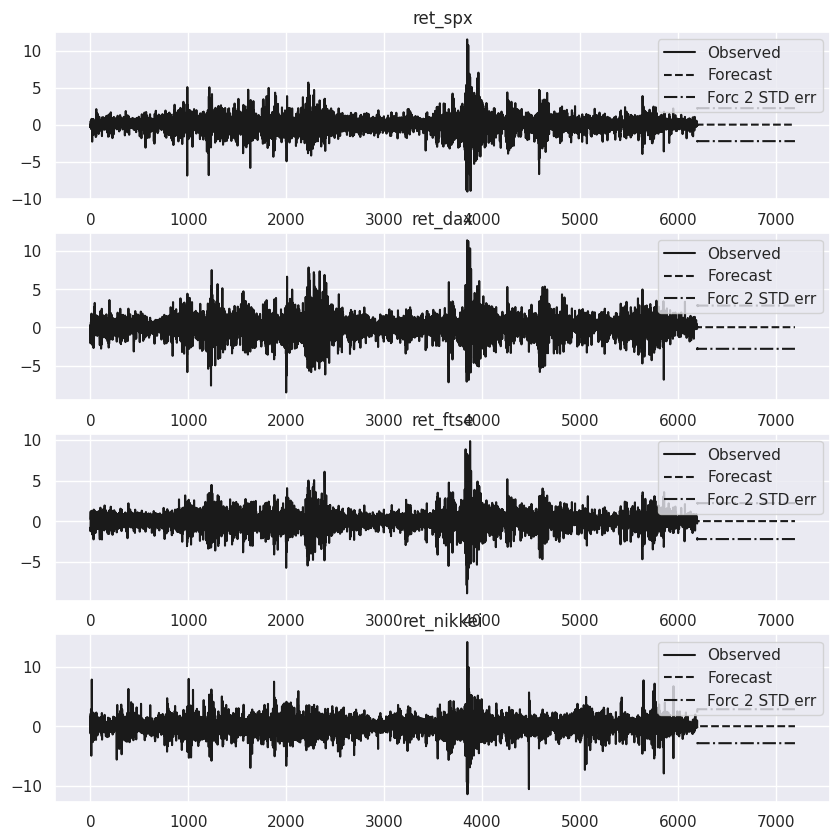

In [ ]:
results_var_ret.plot_forecast(1000)
plt.show()